# Post-hoc model analysis

In [1]:
import sys
import json
import os
import torch
import string
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from confection import Config
from pathlib import Path
from torch.utils.data import DataLoader
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# update the path so we can directly import code from the DVlog
sys.path.append(os.path.dirname(os.path.abspath(os.path.join(os.getcwd(), os.pardir, "DVlog"))))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, "DVlog")))

from DVlog.evaluate import evaluate_model
from DVlog.models.model import UnimodalDVlogModel
from DVlog.utils.dataloaders import MultimodalEmbeddingsDataset
from DVlog.utils.metrics import calculate_performance_measures, calculate_gender_performance_measures
from DVlog.utils.util import ConfigDict, validate_config, process_config, set_seed

## load in the annotations file, the synonyms files and the transcript files

In [2]:
text_dir = Path(r"../data/dvlog_text")
annotations_file = Path(r"../DVlog/dataset/dvlog_labels_v2.csv")

In [3]:
# load in the annotation labels
df_annotations = pd.read_csv(annotations_file)

# select the test set
df_annotations = df_annotations[df_annotations["dataset"] == "test"]
df_annotations

,video_id,label,gender,dataset
1,1,1,f,test
4,4,1,f,test
6,6,1,f,test
12,13,1,f,test
13,15,1,f,test
...,...,...,...,...
800,934,0,f,test
803,937,0,f,test
818,952,0,f,test
822,956,0,f,test


In [4]:
# load in the synonym keywords
depr_synonyms_file1 = Path(r"../data/depression_synonyms_gizem.json")
depr_synonyms_file2 = Path(r"../data/depression_synonyms_paper.json")

# load in the files and combine them into a single list with keywords
with open(depr_synonyms_file1) as current_file:
    depri_synonyms = list(json.loads(current_file.read()).get("depression"))

with open(depr_synonyms_file2) as current_file:
    depri2 = list(json.loads(current_file.read()).get("depression"))

# combine them and remove duplicates
depri_synonyms.extend(depri2)
depri_synonyms = list(set(depri_synonyms))
len(depri_synonyms)

738

In [5]:
# now we load in the texts for every vlog
json_dir = Path(r"../data/dvlog_text")

# loop over each text file and extract the text
text_ref_dict = {}
for json_file in os.listdir(json_dir):
    
    # get the video_id and setup the path to the file
    video_id = int(json_file.split("_")[0])
    json_path = os.path.join(json_dir, json_file)
    
    with open(json_path) as current_file:
        json_dict = json.loads(current_file.read())

    text_ref_dict[video_id] = {
        "text": json_dict["text"],
        "text_segments": [x.get("text") for x in json_dict["segments"]]
    }

# Evaluate detection models
Load in both the normal and keyword filtered model and evaluate them using the test set in order to retrieve the prediction information

In [6]:
models_path = Path(r"../DVlog/trained_models")
normal_model_config = Path(r"../DVlog/model_configs/unimodal/unimodal_mpnet_sent_normal.cfg")
keyw_removed_model_config = Path(r"../DVlog/model_configs/unimodal/unimodal_mpnet_sent_keyw.cfg")

### Normal sentence-level model

In [7]:
# load in the first config dict and evaluate the normal model
config = Config().from_disk(normal_model_config)
config_dict = process_config(config)

# overwrite the annotations_file + data_dir
config_dict.annotations_file = annotations_file
config_dict.data_dir = Path("../DVlog/dataset/sent-embeddings-dataset")
config_dict.encoder1_data_dir = Path("../DVlog/dataset/sent-embeddings-dataset")

# setup the model paths
model_dir_path = Path(os.path.join(models_path, config_dict.model_name))
saved_model_path = Path(os.path.join(model_dir_path, f"model_{config_dict.model_name}.pth"))

# set the seed
set_seed(42)

# setup the original model
saved_model = UnimodalDVlogModel((config_dict.sequence_length, config_dict.encoder1_dim),
                                   d_model=config_dict.dim_model, n_heads=config_dict.uni_n_heads, use_std=config_dict.detectlayer_use_std)

# load in the parameters and set the model to evaluation mode
saved_model.load_state_dict(torch.load(saved_model_path))
saved_model.eval()

# setup the dataset + loader
test_data = MultimodalEmbeddingsDataset("test", config_dict, to_tensor=True, with_protected=True)
test_dataloader = DataLoader(test_data, batch_size=config_dict.batch_size, shuffle=True)

# evaluate both models and retrieve the raw prediction information
norm_pred, norm_truth, norm_protected, norm_video_ids = evaluate_model(saved_model, test_dataloader, config_dict,
                                                                       unpriv_feature="m", verbose=False, get_raw_preds=True)

# retrieve the evaluation metrics to check the model
_, w_precision, w_recall, w_fscore, _ = calculate_performance_measures(norm_truth, norm_pred)
gender_metrics = calculate_gender_performance_measures(norm_truth, norm_pred, norm_protected)

# print the combined and gender-based metrics
print(f"(weighted) -->\nPrecision: {w_precision}\nRecall: {w_recall}\nF1-score: {w_fscore}")
print("Gender-based metrics:\n----------")
for gender_metric in gender_metrics:
    print("Metrics for label {0}:\n---\nPrecision: {1}\nRecall: {2}\nF1-score: {3}\n----------".format(*gender_metric))

Model: unimodal_mpnet_sent_normal
----------
(weighted) -->
Precision: 0.9590831903088421
Recall: 0.9575757575757575
F1-score: 0.9574338230075934
Gender-based metrics:
----------
Metrics for label f:
---
Precision: 0.946496212121212
Recall: 0.9444444444444444
F1-score: 0.9441327723235157
----------
Metrics for label m:
---
Precision: 0.9830409356725146
Recall: 0.9824561403508771
F1-score: 0.9824453274943908
----------


### Keyword filtered sentence-level model

In [8]:
# load in the first config dict and evaluate the normal model
config = Config().from_disk(keyw_removed_model_config)
config_dict = process_config(config)

# overwrite the annotations_file + data_dir
config_dict.annotations_file = annotations_file
config_dict.data_dir = Path("../DVlog/dataset/sent-embeddings-dataset")
config_dict.encoder1_data_dir = Path("../DVlog/dataset/sent-embeddings-dataset")

# setup the model paths
model_dir_path = Path(os.path.join(models_path, config_dict.model_name))
saved_model_path = Path(os.path.join(model_dir_path, f"model_{config_dict.model_name}.pth"))

# set the seed
set_seed(42)

# setup the original model
saved_model = UnimodalDVlogModel((config_dict.sequence_length, config_dict.encoder1_dim),
                                   d_model=config_dict.dim_model, n_heads=config_dict.uni_n_heads, use_std=config_dict.detectlayer_use_std)

# load in the parameters and set the model to evaluation mode
saved_model.load_state_dict(torch.load(saved_model_path))
saved_model.eval()

# setup the dataset + loader
test_data = MultimodalEmbeddingsDataset("test", config_dict, to_tensor=True, with_protected=True)
test_dataloader = DataLoader(test_data, batch_size=config_dict.batch_size, shuffle=True)

# evaluate both models and retrieve the raw prediction information
keyw_pred, keyw_truth, keyw_protected, keyw_video_ids = evaluate_model(saved_model, test_dataloader, config_dict,
                                                                       unpriv_feature="m", verbose=False, get_raw_preds=True)

# retrieve the evaluation metrics to check the model
_, w_precision, w_recall, w_fscore, _ = calculate_performance_measures(keyw_truth, keyw_pred)
gender_metrics = calculate_gender_performance_measures(keyw_truth, keyw_pred, keyw_protected)

# print the combined and gender-based metrics
print(f"(weighted) -->\nPrecision: {w_precision}\nRecall: {w_recall}\nF1-score: {w_fscore}")
print("Gender-based metrics:\n----------")
for gender_metric in gender_metrics:
    print("Metrics for label {0}:\n---\nPrecision: {1}\nRecall: {2}\nF1-score: {3}\n----------".format(*gender_metric))

Model: unimodal_mpnet_sent_keyw
----------
(weighted) -->
Precision: 0.9114926438296004
Recall: 0.9090909090909091
F1-score: 0.9086164534440396
Gender-based metrics:
----------
Metrics for label f:
---
Precision: 0.9383820314052871
Recall: 0.9351851851851852
F1-score: 0.9347008547008547
----------
Metrics for label m:
---
Precision: 0.8612598493752992
Recall: 0.8596491228070176
F1-score: 0.8593892137751786
----------


## in-depth analysis
As can be seen from both the models above, the F1-score for the male group drops from $0.982$ to $0.859$ (a decrease of $0.123$) when we filter on sentences containing keywords.

first we retrieve the predictions from both the normal and the keyword-filtered model and put both of them into a dataframe.

In [9]:
# flatten the predictions of the normal model
norm_pred = np.argmax(np.concatenate(norm_pred), axis=1)
norm_video_ids = np.array(list(chain.from_iterable(norm_video_ids)))

# flatten the predictions of the keyword model
keyw_pred = np.argmax(np.concatenate(keyw_pred), axis=1)
keyw_video_ids = np.array(list(chain.from_iterable(keyw_video_ids)))

# build the dataframes
df_norm = pd.DataFrame({"video_id": norm_video_ids, "pred_normal": norm_pred})
df_keyw = pd.DataFrame({"video_id": keyw_video_ids, "pred_keyw": keyw_pred})

In [10]:
# merge the predictions back into the dataframe
df_annotations = pd.merge(df_annotations, df_norm, left_on="video_id", right_on="video_id", how="left")
df_annotations = pd.merge(df_annotations, df_keyw, left_on="video_id", right_on="video_id", how="left")
df_annotations

,video_id,label,gender,dataset,pred_normal,pred_keyw
0,1,1,f,test,1,1
1,4,1,f,test,0,0
2,6,1,f,test,1,1
3,13,1,f,test,1,1
4,15,1,f,test,1,1
...,...,...,...,...,...,...
160,934,0,f,test,0,0
161,937,0,f,test,0,0
162,952,0,f,test,0,0
163,956,0,f,test,0,1


## Comparison of confusion matrices
We now build a plot which presents the confusion matrices for two models used in predicting depression: one utilizing unchanged sentence embeddings and the other employing keyword filtering to remove sentences before using the remaining embeddings for prediction. The overall confusion matrices are shown alongside gender-specific confusion matrices, highlighting the performance and potential gender biases of each model.

In [11]:
labels = [0, 1]

# select the male and female examples
df_data_m = df_annotations[df_annotations["gender"] == "m"]
df_data_f = df_annotations[df_annotations["gender"] == "f"]

# retrieve the confusion matrices for the normal model
normal_cm_both = confusion_matrix(df_annotations["label"], df_annotations["pred_normal"], labels=labels)
normal_cm_m = confusion_matrix(df_data_m["label"], df_data_m["pred_normal"], labels=labels)
normal_cm_f = confusion_matrix(df_data_f["label"], df_data_f["pred_normal"], labels=labels)

# retrieve the confusion matrices for the keyword-filtered model
keyw_cm_both = confusion_matrix(df_annotations["label"], df_annotations["pred_keyw"], labels=labels)
keyw_cm_m = confusion_matrix(df_data_m["label"], df_data_m["pred_keyw"], labels=labels)
keyw_cm_f = confusion_matrix(df_data_f["label"], df_data_f["pred_keyw"], labels=labels)

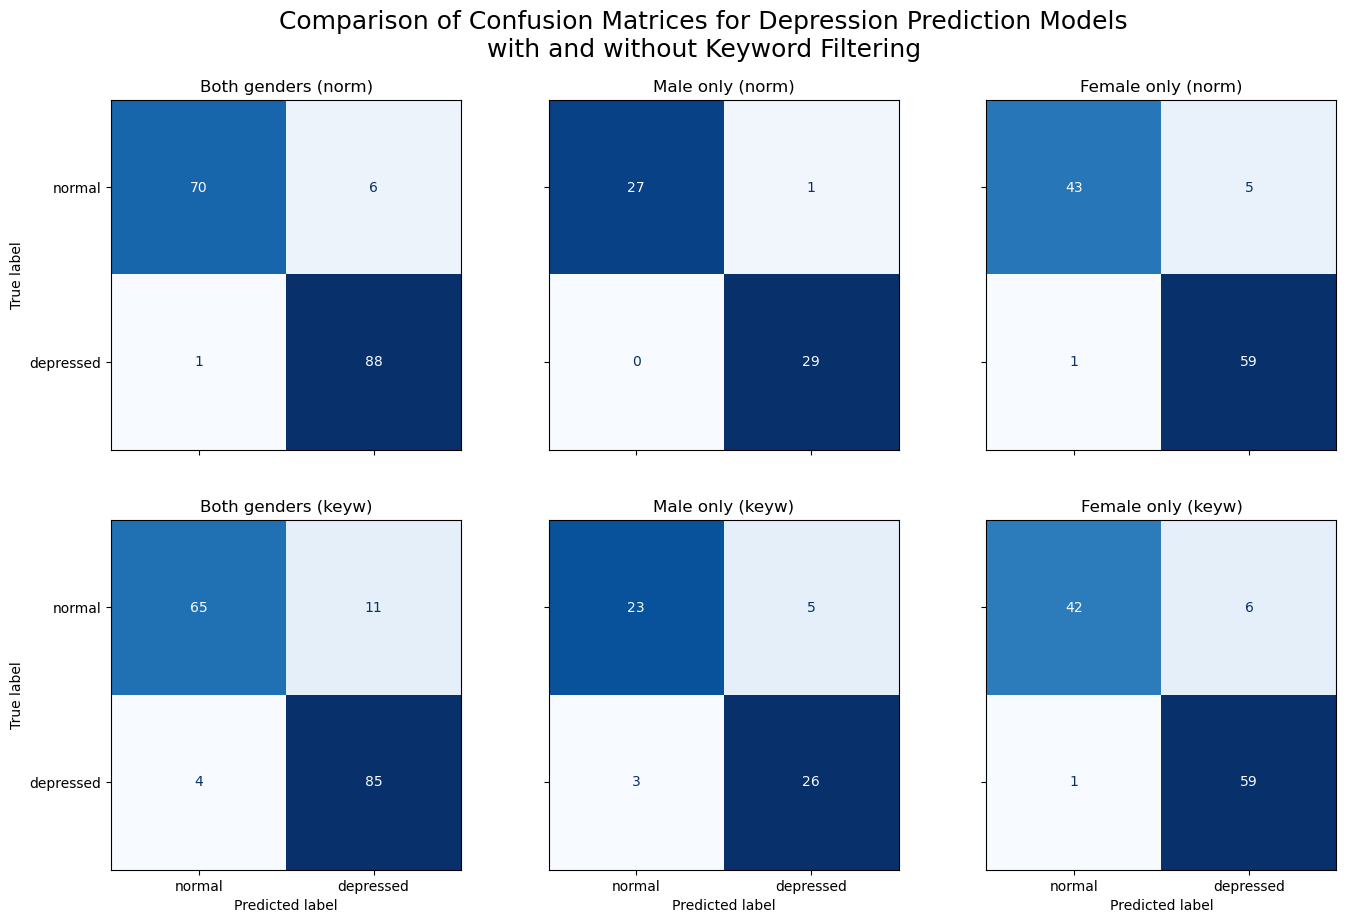

In [12]:
# make a confusion matrix for the predictions
title_size = 18
sup_title_size = 12
cmap = "Blues"  # Try "Greens". Change the color of the confusion matrix.
colorbar = False
display_labels = ["normal", "depressed"]

# Create subplots for given confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# plot the confusion matrices for the normal model
# Plot the first confusion matrix (Model 1) at position (0, 0)
axs[0, 0].set_title("Both genders (norm)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=normal_cm_both, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[0, 0], colorbar=colorbar)
axs[0, 0].xaxis.set_ticklabels(["", ""])
axs[0, 0].set_xlabel("")
# axs[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot the second confusion matrix
axs[0, 1].set_title("Male only (norm)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=normal_cm_m, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[0, 1], colorbar=colorbar)
axs[0, 1].xaxis.set_ticklabels(["", ""])
axs[0, 1].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")  # remove the y-label

# Plot the third confusion matrix
axs[0, 2].set_title("Female only (norm)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=normal_cm_f, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[0, 2], colorbar=colorbar)
axs[0, 2].xaxis.set_ticklabels(["", ""])
axs[0, 2].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[0, 2].set_xlabel("")
axs[0, 2].set_ylabel("")  # remove the y-label


# plot the confusion matrices for the keyw-filtered model
# Plot the first confusion matrix (Model 2) at position (1, 0)
axs[1, 0].set_title("Both genders (keyw)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=keyw_cm_both, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[1, 0], colorbar=colorbar)

# Plot the second confusion matrix
axs[1, 1].set_title("Male only (keyw)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=keyw_cm_m, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[1, 1], colorbar=colorbar)
axs[1, 1].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[1, 1].set_ylabel("")  # remove the y-label

# # Plot the third confusion matrix
axs[1, 2].set_title("Female only (keyw)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=keyw_cm_f, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[1, 2], colorbar=colorbar)
axs[1, 2].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[1, 2].set_ylabel("")  # remove the y-label

# # Set the figure's suptitle and display the plot
fig.suptitle("Comparison of Confusion Matrices for Depression Prediction Models\nwith and without Keyword Filtering", size=title_size, y=0.97)

plt.show()

## Word usage analysis for the incorrect predictions
In the comparison above, we see that for the normal model for males only makes $1$ mistake. However, in the keyword-filtered model the model introduces $5$ False Positives and $3$ False Negatives.

Now we find out what sentences were removed and what was in these sentences

In [13]:
# first we select all examples from the test dataset that are male
df_filtered = df_annotations[(df_annotations["dataset"] == "test") & (df_annotations["gender"] == "m")]

# now we select the instances for which the label and prediction don't coincide
df_filtered = df_filtered[df_filtered["label"] != df_filtered["pred_keyw"]]
df_filtered

,video_id,label,gender,dataset,pred_normal,pred_keyw
13,63,1,m,test,1,0
23,105,1,m,test,1,0
68,460,1,m,test,1,0
96,585,0,m,test,0,1
100,615,0,m,test,1,1
105,642,0,m,test,0,1
121,747,0,m,test,0,1
159,931,0,m,test,0,1


### Check the FN examples
The False Negative examples are especially interesting, since the removal of the sentences containing the keywords for these vlogs made the model wrongfully predict that there is no depression to be found.

In [14]:
def clean_text(text: str, unicode_pattern: str = "NFKD") -> str:
    text = text.replace("\n", "").strip()  # Remove newlines and trailing whitespace
    text = text.translate(str.maketrans("", "", string.digits))  # Remove all numbers with lookup table
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation with lookup table
    text = " ".join(text.split()) # Remove excess whitespace in between words
    text = unicodedata.normalize(unicode_pattern, text)  # Strip accents from characters

    return text

In [15]:
# we first extract and review the FN examples
FN_skipped_sentences = {}

for _, row in df_filtered[df_filtered["label"] == 1].iterrows():
    # get the texts
    video_id = row.video_id
    FN_skipped_sentences[video_id] = []
    texts = text_ref_dict.get(video_id).get("text_segments")

    # clean the texts
    texts = [clean_text(text) for text in texts if len(clean_text(text).split()) > 1]

    # check for each keyword on each sentence
    for sentence in texts:
        for keyw in depri_synonyms:
            if keyw in sentence:
                # we found the keyword in this sentence so save the sentence
                FN_skipped_sentences[video_id].append((keyw, sentence))
                break

FN_skipped_sentences

{63: [('pression',
   'And that is depression I was diagnosed with depression at a very young age'),
  ('pression',
   'What I want this vlog to be about is ones experiences with depression not necessarily my exes'),
  ('pression',
   'Dont be this asshole because he doesnt know how to deal with his depression right'),
  ('pression',
   'I always find it really hard to talk to individuals about depression like oneonone')],
 105: [('pression', 'Suicide and Depression'),
  ('pression',
   'In my life I have gone through depression since I was eight and I still struggle with'),
  ('suicide', 'In my life I have attempted to commit suicide three times'),
  ('pression',
   'And she admitted that she has struggled with depression but she rose up and faced the')],
 460: [('feeling down',
   'But yeah the reason I made it was because I was feeling down that day and I felt like I needed an outlet and that really helped'),
  ('pression', 'basically killed herself because of depression and'),
  ('

In [16]:
# now we extract and review the FP examples
FP_skipped_sentences = {}

for _, row in df_filtered[df_filtered["label"] == 0].iterrows():
    # get the texts
    video_id = row.video_id
    FP_skipped_sentences[video_id] = []
    texts = text_ref_dict.get(video_id).get("text_segments")

    # clean the texts
    texts = [clean_text(text) for text in texts if len(clean_text(text).split()) > 1]

    # check for each keyword on each sentence
    for sentence in texts:
        for keyw in depri_synonyms:
            if keyw in sentence:
                # we found the keyword in this sentence so save the sentence
                FP_skipped_sentences[video_id].append((keyw, sentence))
                break

FP_skipped_sentences

{585: [],
 615: [('emotional',
   'So the first piece of advice Id give you Toby is number one do not do not get emotionally'),
  ('pain', 'a pain in the ass')],
 642: [],
 747: [('emotional',
   'tell whats positive or whats negative and because the brain is very emotional it will')],
 931: []}

# New experiment
So above we use two specifically trained models where the first one was trained normally and the second one was trained on keyword-filtered sentences. However, what happens when we use the normally trained model and let it predict the keyword-filtered features?

We first start with setting up the model for inference

In [17]:
# load in the first config dict and evaluate the normal model
config = Config().from_disk(normal_model_config)
config_dict = process_config(config)

# overwrite the annotations_file + data_dir
config_dict.annotations_file = annotations_file
config_dict.data_dir = Path("../DVlog/dataset/sent-embeddings-dataset")
config_dict.encoder1_data_dir = Path("../DVlog/dataset/sent-embeddings-dataset")
config_dict.encoder1_feature_name = "sent_mpnet_keyw" # overwrite the feature name so the keyword-filtered features are chosen

# setup the model paths
model_dir_path = Path(os.path.join(models_path, config_dict.model_name))
saved_model_path = Path(os.path.join(model_dir_path, f"model_{config_dict.model_name}.pth"))

# set the seed
set_seed(42)

# setup the original model
saved_model = UnimodalDVlogModel((config_dict.sequence_length, config_dict.encoder1_dim),
                                   d_model=config_dict.dim_model, n_heads=config_dict.uni_n_heads, use_std=config_dict.detectlayer_use_std)

# load in the parameters and set the model to evaluation mode
saved_model.load_state_dict(torch.load(saved_model_path))
saved_model.eval()

# setup the dataset + loader
test_data = MultimodalEmbeddingsDataset("test", config_dict, to_tensor=True, with_protected=True)
test_dataloader = DataLoader(test_data, batch_size=config_dict.batch_size, shuffle=True)

# evaluate both models and retrieve the raw prediction information
test_keyw_pred, test_keyw_truth, test_keyw_protected, test_keyw_video_ids = evaluate_model(saved_model, test_dataloader, config_dict, 
                                                                                           unpriv_feature="m", verbose=False, get_raw_preds=True)

# retrieve the evaluation metrics to check the model
_, w_precision, w_recall, w_fscore, _ = calculate_performance_measures(test_keyw_truth, test_keyw_pred)
gender_metrics = calculate_gender_performance_measures(test_keyw_truth, test_keyw_pred, test_keyw_protected)

# print the combined and gender-based metrics
print(f"(weighted) -->\nPrecision: {w_precision}\nRecall: {w_recall}\nF1-score: {w_fscore}")
print("Gender-based metrics:\n----------")
for gender_metric in gender_metrics:
    print("Metrics for label {0}:\n---\nPrecision: {1}\nRecall: {2}\nF1-score: {3}\n----------".format(*gender_metric))

Model: unimodal_mpnet_sent_normal
----------
(weighted) -->
Precision: 0.9164527629233512
Recall: 0.9151515151515152
F1-score: 0.9152640462985291
Gender-based metrics:
----------
Metrics for label f:
---
Precision: 0.9448340345956054
Recall: 0.9444444444444444
F1-score: 0.9443088013021742
----------
Metrics for label m:
---
Precision: 0.876744290393503
Recall: 0.8596491228070176
F1-score: 0.8583431282921945
----------


## small comparison of performance
\begin{array} {|r|r|}\hline  & Fscore (Overall) & Fscore (Male) & Fscore (Female) \\ \hline normal model & 0.957 & 0.982 & 0.944 \\ \hline keyw model & 0.909 & 0.859 & 0.935 \\ \hline normal model (with keyw test) & 0.915 & 0.858 & 0.944 \\ \hline  \end{array}

In [18]:
# flatten the predictions of the keyword model
test_keyw_pred = np.argmax(np.concatenate(test_keyw_pred), axis=1)
test_keyw_video_ids = np.array(list(chain.from_iterable(test_keyw_video_ids)))

# build the dataframes
df_test_keyw = pd.DataFrame({"video_id": test_keyw_video_ids, "pred_test_keyw": test_keyw_pred})
df_annotations = pd.merge(df_annotations, df_test_keyw, left_on="video_id", right_on="video_id", how="left")
df_annotations

,video_id,label,gender,dataset,pred_normal,pred_keyw,pred_test_keyw
0,1,1,f,test,1,1,1
1,4,1,f,test,0,0,0
2,6,1,f,test,1,1,1
3,13,1,f,test,1,1,1
4,15,1,f,test,1,1,1
...,...,...,...,...,...,...,...
160,934,0,f,test,0,0,0
161,937,0,f,test,0,0,0
162,952,0,f,test,0,0,0
163,956,0,f,test,0,1,0


In [19]:
# select the male and female examples
df_data_m = df_annotations[df_annotations["gender"] == "m"]
df_data_f = df_annotations[df_annotations["gender"] == "f"]

# retrieve the confusion matrices for the keyword-filtered model
test_keyw_cm_both = confusion_matrix(df_annotations["label"], df_annotations["pred_test_keyw"], labels=labels)
test_keyw_cm_m = confusion_matrix(df_data_m["label"], df_data_m["pred_test_keyw"], labels=labels)
test_keyw_cm_f = confusion_matrix(df_data_f["label"], df_data_f["pred_test_keyw"], labels=labels)

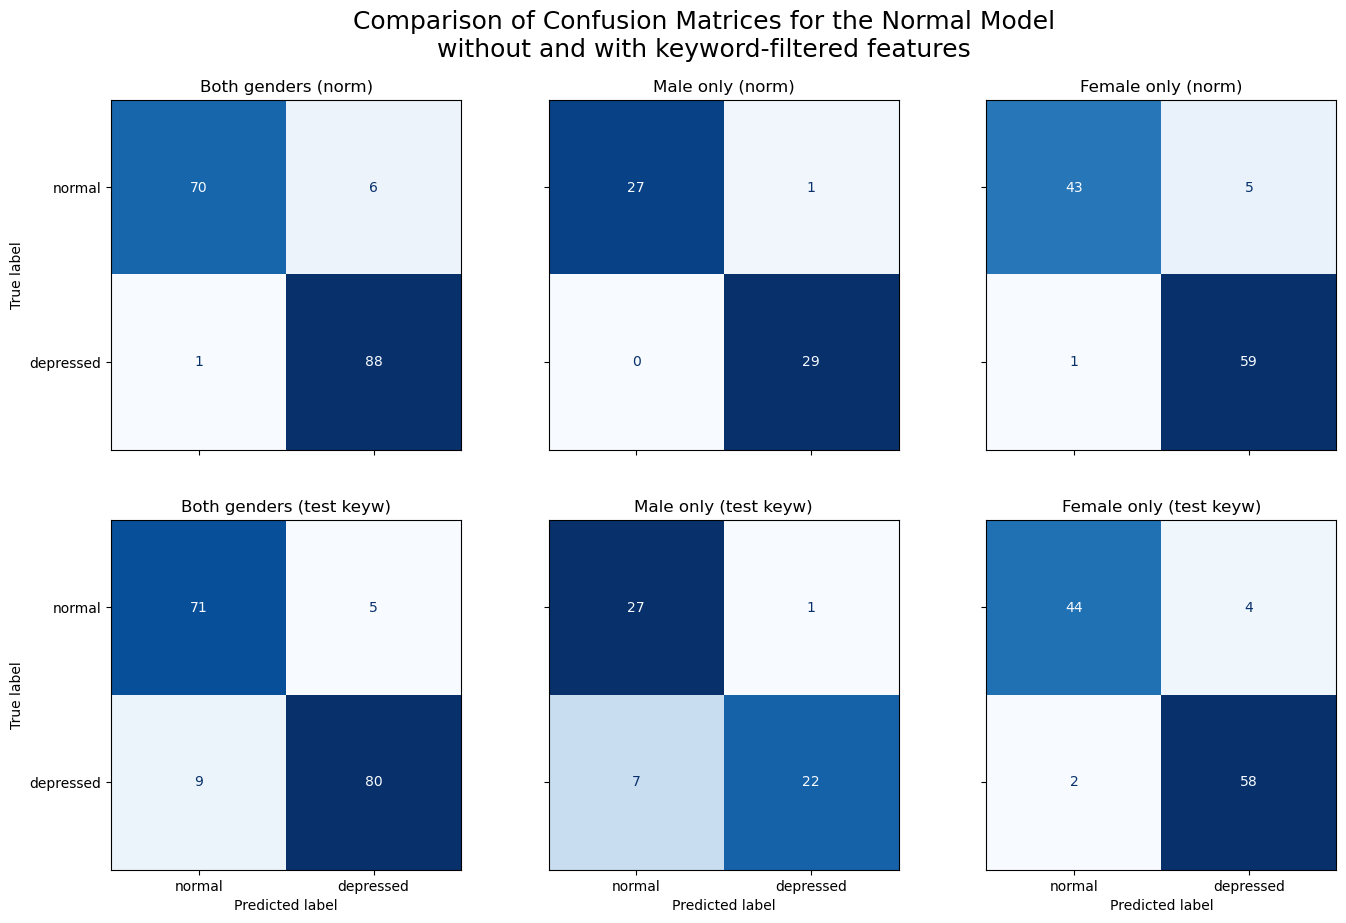

In [20]:
# make a confusion matrix for the predictions
title_size = 18
sup_title_size = 12
cmap = "Blues"  # Try "Greens". Change the color of the confusion matrix.
colorbar = False
display_labels = ["normal", "depressed"]

# Create subplots for given confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# plot the confusion matrices for the normal model
# Plot the first confusion matrix (Model 1) at position (0, 0)
axs[0, 0].set_title("Both genders (norm)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=normal_cm_both, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[0, 0], colorbar=colorbar)
axs[0, 0].xaxis.set_ticklabels(["", ""])
axs[0, 0].set_xlabel("")
# axs[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot the second confusion matrix
axs[0, 1].set_title("Male only (norm)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=normal_cm_m, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[0, 1], colorbar=colorbar)
axs[0, 1].xaxis.set_ticklabels(["", ""])
axs[0, 1].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")  # remove the y-label

# Plot the third confusion matrix
axs[0, 2].set_title("Female only (norm)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=normal_cm_f, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[0, 2], colorbar=colorbar)
axs[0, 2].xaxis.set_ticklabels(["", ""])
axs[0, 2].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[0, 2].set_xlabel("")
axs[0, 2].set_ylabel("")  # remove the y-label


# plot the confusion matrices for the keyw-filtered model
# Plot the first confusion matrix (Model 2) at position (1, 0)
axs[1, 0].set_title("Both genders (test keyw)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=test_keyw_cm_both, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[1, 0], colorbar=colorbar)

# Plot the second confusion matrix
axs[1, 1].set_title("Male only (test keyw)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=test_keyw_cm_m, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[1, 1], colorbar=colorbar)
axs[1, 1].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[1, 1].set_ylabel("")  # remove the y-label

# # Plot the third confusion matrix
axs[1, 2].set_title("Female only (test keyw)", size=sup_title_size)
ConfusionMatrixDisplay(confusion_matrix=test_keyw_cm_f, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axs[1, 2], colorbar=colorbar)
axs[1, 2].yaxis.set_ticklabels(["", ""])  # remove the y-axis labels
axs[1, 2].set_ylabel("")  # remove the y-label

# # Set the figure's suptitle and display the plot
fig.suptitle("Comparison of Confusion Matrices for the Normal Model\nwithout and with keyword-filtered features", size=title_size, y=0.97)

plt.show()

## Word usage analysis for the incorrect predictions
In the comparison above, we see that for the normal model for males only makes $1$ mistake. However, when we feed in the keyword-filtered features, we see that the model now has $7$ False Negatives.

Now we find out what sentences were removed and what was in these sentences

In [21]:
# first we select all examples from the test dataset that are male
df_filtered = df_annotations[(df_annotations["dataset"] == "test") & (df_annotations["gender"] == "m")]

# now we select the instances for which the label and prediction don't coincide
df_mismatch = df_filtered[df_filtered["label"] != df_filtered["pred_test_keyw"]]
df_mismatch

,video_id,label,gender,dataset,pred_normal,pred_keyw,pred_test_keyw
13,63,1,m,test,1,0,0
21,95,1,m,test,1,1,0
23,105,1,m,test,1,0,0
34,168,1,m,test,1,1,0
39,192,1,m,test,1,1,0
55,379,1,m,test,1,1,0
68,460,1,m,test,1,0,0
100,615,0,m,test,1,1,1


In [25]:
# we first extract and review the FN examples
FN_test_skipped_sentences = {}

for _, row in df_mismatch[df_mismatch["label"] == 1].iterrows():
    # get the texts
    video_id = row.video_id
    FN_test_skipped_sentences[video_id] = []
    texts = text_ref_dict.get(video_id).get("text_segments")

    # clean the texts
    texts = [clean_text(text) for text in texts if len(clean_text(text).split()) > 1]

    # check for each keyword on each sentence
    for sentence in texts:
        for keyw in depri_synonyms:
            if keyw in sentence:
                # we found the keyword in this sentence so save the sentence
                FN_test_skipped_sentences[video_id].append((keyw, sentence))
                break
# FN_test_skipped_sentences

In [23]:
# let's check the distribution of the keywords on the other positive samples that were correctly predicted
df_filtered = df_annotations[(df_annotations["dataset"] == "test") & (df_annotations["gender"] == "m")]
df_positives = df_filtered[df_filtered["label"] == 1]

TP_test_skipped_sentences = {}
for _, row in df_positives[df_positives["pred_test_keyw"] == 1].iterrows():
    # get the texts
    video_id = row.video_id
    TP_test_skipped_sentences[video_id] = []
    texts = text_ref_dict.get(video_id).get("text_segments")

    # clean the texts
    texts = [clean_text(text) for text in texts if len(clean_text(text).split()) > 1]

    # check for each keyword on each sentence
    for sentence in texts:
        for keyw in depri_synonyms:
            if keyw in sentence:
                # we found the keyword in this sentence so save the sentence
                TP_test_skipped_sentences[video_id].append((keyw, sentence))
                break